In [1]:
import numpy as np
from numpy.random import RandomState, default_rng

import pandas as pd
from functools import reduce

import matplotlib.pyplot as plt
import seaborn as sns
import itertools

import math

from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, ConfusionMatrixDisplay, auc, recall_score, precision_score, precision_recall_curve, PrecisionRecallDisplay, classification_report

from hyperopt import hp, fmin, STATUS_OK, tpe
from hyperopt.early_stop import no_progress_loss

## Creating Datasets
* Small: Top 5 non-text based featuress from 1% dataset
* Medium: Top 24 non-text based features from 5% dataset
* Large: Top 45 non-text based features from 10% dataset
* Validation: Top 5,24,45 non-text based features from 1% dataset

All datasets contain two classes (i.e. attack or binary) and 47 features. We then select the top 5 features for each dataset.

Small, medium and large will be split into train and test datasets. Train is used to create detectors and test is used for the evaluation function. Validation is used to optimize detecto radius with Hyperopt.

In [2]:
#Creating the datasets
df_1percent = pd.read_csv("/kaggle/input/creating-a-smaller-dataset-for-ciciot2023/0.01percent_2classes.csv")
df_5percent = pd.read_csv("/kaggle/input/creating-a-smaller-dataset-for-ciciot2023/0.05percent_2classes.csv")
df_10percent = pd.read_csv("/kaggle/input/creating-a-smaller-dataset-for-ciciot2023/0.1percent_2classes.csv")

df_val = pd.read_csv("/kaggle/input/creating-a-smaller-dataset-for-ciciot2023/0.01percent_validation_2classes.csv")

In [3]:
print(df_1percent.shape, df_5percent.shape, df_10percent.shape, df_val.shape)

(466869, 47) (2334325, 47) (4668665, 47) (466761, 47)


In [4]:
# Features
top5_feats = list(pd.read_csv("/kaggle/input/feature-importance-study-on-the-ciciot2023-export/top5.csv")["Feature"])
top24_feats = list(pd.read_csv("/kaggle/input/feature-importance-study-on-the-ciciot2023-export/top24.csv")["Feature"])
topall_feats = list(pd.read_csv("/kaggle/input/feature-importance-study-on-the-ciciot2023-export/topall.csv")["Feature"])

top5_feats.append("benign")
top24_feats.append("benign")
topall_feats.append("benign")

In [5]:
top5_feats

['iat', 'header_length', 'magnitude', 'rst_count', 'max', 'benign']

In [6]:
df_small = df_1percent[top5_feats]
df_med = df_5percent[top24_feats]
df_large = df_10percent[topall_feats]

df_val_small = df_val[top5_feats]
df_val_med = df_val[top24_feats]
df_val_large = df_val[topall_feats]

In [7]:
print(df_small.shape, df_med.shape, df_large.shape)
print(df_val_small.shape, df_val_med.shape, df_val_large.shape)

(466869, 6) (2334325, 25) (4668665, 46)
(466761, 6) (466761, 25) (466761, 46)


# Preprocessing
1. Normalize using Sci-Kit Learn's StandardScaler()
2. Split into detectors, and scaled attacks and scaled benigns (for testing)

In [8]:
def preprocessing(df_main, df_val):
    X = df_main.drop("benign", axis = 1)
    y = df_main["benign"].astype(np.float32)
    
    ratio_att_to_ben = (y.value_counts()[0.0])/(y.value_counts()[1.0])

    X_val = df_val.drop("benign", axis = 1)
    y_val = df_val["benign"].astype(np.float32)
    
    val_ratio_att_to_ben = (y_val.value_counts()[0.0])/(y_val.value_counts()[1.0])
    
    # Convert to numpy
    X = X.to_numpy().astype(np.float32) #All data w/o labels
    y = y.to_numpy().astype(np.float32) #All labels
    
    # Normalization
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(X)
    
    benigns_scaled = data_scaled[y.squeeze() == True, :]
    attacks_scaled = data_scaled[y.squeeze() == False, :]
    
    print(f"scaler mean: {scaler.mean_.astype(np.float32)}, scaler var: {scaler.var_.astype(np.float32)}")
    
    # Normalization of Validation Dataset
    val_scaler = ColumnTransformer([
        ('somename', StandardScaler(), X_val.columns)
    ], remainder='passthrough')
    scaled_val = val_scaler.fit_transform(df_val)
    
    detectors_set, scaled_benigns_test = train_test_split(benigns_scaled, test_size=0.3, random_state = 42)
    scaled_attacks_train, scaled_attacks_test = train_test_split(attacks_scaled, test_size=0.3, random_state = 42)
    
    return detectors_set, scaled_benigns_test, scaled_attacks_test, scaled_val, int(ratio_att_to_ben), int(val_ratio_att_to_ben)

### Small, Medium and Large Datasets

In [9]:
# Small Dataset
small_det, small_ben_test, small_att_test, small_val, small_ratio_att_to_ben, small_val_ratio_att_to_ben = preprocessing(df_small, df_val_small)
print(small_det.shape, small_ben_test.shape, small_att_test.shape, small_val.shape)

# Medium Dataset
med_det, med_ben_test, med_att_test, med_val, med_ratio_att_to_ben, med_val_ratio_att_to_ben = preprocessing(df_med, df_val_med)
print(med_det.shape, med_ben_test.shape, med_att_test.shape, med_val.shape)

# Large Dataset
large_det, large_ben_test, large_att_test, large_val, large_ratio_att_to_ben, large_val_ratio_att_to_ben  = preprocessing(df_large, df_val_large)
print(large_det.shape, large_ben_test.shape, large_att_test.shape, large_val.shape)

scaler mean: [8.3157144e+07 7.6943680e+04 1.3118273e+01 3.8499920e+01 1.8166219e+02], scaler var: [2.9066282e+14 2.1407808e+11 7.4370697e+01 1.0545658e+05 2.7581962e+05]
(7686, 5) (3295, 5) (136767, 5) (466761, 6)
scaler mean: [8.31867200e+07 7.67192031e+04 1.31205196e+01 3.83366890e+01
 1.81906525e+02 1.24665955e+02 5.65363550e+00 1.24624290e+02
 6.17433643e+00 9.64782238e-02 1.30702576e+03 9.15912704e+01
 8.93214160e+03 8.93214160e+03 3.30482155e-01 4.70852165e+01
 6.63340912e+01 3.06868145e+04 3.33165359e+01 9.49866199e+00
 7.42634386e-02 1.41516937e+02 5.50548881e-02 3.76982644e-05], scaler var: [2.90543733e+14 2.11809174e+11 7.43846207e+01 1.04806289e+05
 2.74205312e+05 5.83438203e+04 6.57023203e+04 5.79748320e+04
 5.05823730e+03 5.42926826e-02 6.76950700e+06 1.94881074e+04
 9.60522240e+09 9.60522240e+09 4.40479666e-01 5.12790742e+04
 1.94201294e+02 9.73378109e+10 2.56325703e+04 6.70799196e-01
 1.20611764e-01 4.43793762e+02 5.20238467e-02 3.76968419e-05]
(38437, 24) (16474, 24) (6

In [10]:
# Set number of detectors, test data points and validation data points

NUM_DETECTORS = 100
NUM_BENIGN = 1000

# Small Dataset
DETECTORS_S = small_det[:NUM_DETECTORS]
BENIGN_TEST_S = small_ben_test[:NUM_BENIGN]
ATTACK_TEST_S = small_att_test[:NUM_BENIGN*small_ratio_att_to_ben]

# Medium Dataset
DETECTORS_M = med_det[:NUM_DETECTORS]
BENIGN_TEST_M = med_ben_test[:NUM_BENIGN]
ATTACK_TEST_M = med_att_test[:NUM_BENIGN*med_ratio_att_to_ben]

# Large Dataset
DETECTORS_L = large_det[:NUM_DETECTORS]
BENIGN_TEST_L = large_ben_test[:NUM_BENIGN]
ATTACK_TEST_L = large_att_test[:NUM_BENIGN*large_ratio_att_to_ben]

In [11]:
NUM_BENIGN_VAL = 1000

fltr_ben = np.asarray([1.])
fltr_att = np.asarray([0.])

n_sm = small_val.shape[-1] - 1
n_md = med_val.shape[-1] - 1
n_lg = large_val.shape[-1] - 1

val_ben_sm = np.delete(small_val[np.in1d(small_val[:,n_sm], fltr_ben)], n_sm, 1)[:NUM_BENIGN_VAL]
val_att_sm = np.delete(small_val[np.in1d(small_val[:,n_sm], fltr_att)], n_sm, 1)[:NUM_BENIGN_VAL*small_val_ratio_att_to_ben]

val_ben_md = np.delete(med_val[np.in1d(med_val[:,n_md], fltr_ben)], n_md, 1)[:NUM_BENIGN_VAL]
val_att_md = np.delete(med_val[np.in1d(med_val[:,n_md], fltr_att)], n_md, 1)[:NUM_BENIGN_VAL*med_val_ratio_att_to_ben]

val_ben_lg = np.delete(large_val[np.in1d(large_val[:,n_lg], fltr_ben)], n_lg, 1)[:NUM_BENIGN_VAL]
val_att_lg = np.delete(large_val[np.in1d(large_val[:,n_lg], fltr_att)], n_lg, 1)[:NUM_BENIGN_VAL*large_val_ratio_att_to_ben]

print(val_ben_sm)
print(val_att_sm)

[[ 4.89251975  1.40479982  5.36891253  1.80875071  8.00727335]
 [-4.88278142 -0.15830568  0.01076975 -0.07873116 -0.03413056]
 [-4.88278142  0.34706964  1.88565204  1.86067173  1.54081798]
 ...
 [-4.88278142  4.13670723  2.26400822  7.60558015  3.22920978]
 [ 4.89257082  0.27012998  5.3322957   0.48323755  5.26493872]
 [-4.88278142  2.95214505  5.48846425  4.06884227  4.44223833]]
[[-0.0050718  -0.1666431  -0.31604226 -0.11843548 -0.24245708]
 [ 0.01090782 -0.16658025 -0.31604226 -0.11843548 -0.24245708]
 [-0.01116059 -0.16663226 -0.3159238  -0.11843548 -0.24222982]
 ...
 [ 0.00992159 -0.1666431  -0.31604226 -0.11843548 -0.24245708]
 [-0.00283458 -0.16676013 -0.4570232  -0.11843548 -0.26245643]
 [ 0.00814779 -0.16659975 -0.27905893 -0.11843548 -0.18245904]]


# P-R Curve and Optimal Radius Search

In [12]:
def psa(r, detrs, ben, att):
    
    def affinity(v1 : np.ndarray, v2 : np.ndarray):
        ''' Manhattan distance between vectors '''
        return np.sum(np.abs(v1 - v2), axis=-1)

    #True Positive: Self correctly classified
    TP = 0
    #False Positive: Non-Self incorrectly classified
    FP = 0
    #True Negative: Non-Self correctly classified
    TN = 0
    #False Negative: Self incorrectly classified
    FN = 0

    # Test benign data
    for t in ben:
        for i in range(0, len(detrs)-1):
          aff = affinity(t, detrs[i])
          if aff < r:
            TP += 1
            break
    FN = len(ben) - TP

    # Test attack data
    for t in att:
        for i in range(0, len(detrs)-1):
          aff = affinity(t, detrs[i])
          if aff < r:
            FP += 1
            break
    TN = len(att) - FP

    print(f"Results for r = {r} | TN: {TN}, FP: {FP}, FN: {FN}, TP: {TP}")

    detection_rate = TN/(TN+FP)
    false_alarm_rate = FN/(FN+TP)
    
    if (TP + FP) != 0.0:
        precision = TP/(TP + FP)
    if (TP + FP) == 0.0:
        precision = 0
    if (TP + FN) != 0.0:
        recall = TP/(TP + FN)
    if (TP + FN) == 0.0:
        recall = 0

    loss = 1 - (detection_rate - false_alarm_rate)

    return loss, detection_rate, false_alarm_rate, precision, recall

In [13]:
def pr_curve(min_radius, max_radius, num_steps, detrs, ben, att):

    # For radius-loss curve
    r_values = np.linspace(min_radius,max_radius, num_steps)
    loss_values = []

    # For detection rate - false alarm rate curve
    detection_rates = []
    false_alarm_rates = []

    # For PR curve
    precisions = []
    recalls = []

    for r in r_values:
        loss, detection_rate, false_alarm_rate, precision, recall = psa(r, detrs, ben, att)
        loss_values.append(loss)
        detection_rates.append(detection_rate)
        false_alarm_rates.append(false_alarm_rate)
        precisions.append(precision)
        recalls.append(recall)
        
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
    
    figure, axis = plt.subplots(1, 3, constrained_layout=True)
    
    # For radius-loss curve
    axis[0].plot(r_values, loss_values) 
    axis[0].set_title("Loss Curve")
    axis[0].set_xlabel("Radius")
    axis[0].set_ylabel("Loss")
    
    # For detection rate - false alarm rate curve
    axis[1].plot(false_alarm_rates, detection_rates) 
    axis[1].set_title("Det. Rate - F. Alarm Rate") 
    axis[1].set_xlabel("F. Alarm Rate")
    axis[1].set_ylabel("Det. Rate")
    
    # For Precision Recall curve
    axis[2].plot(recalls, precisions) 
    axis[2].set_title("P-R Curve") 
    axis[2].set_xlabel("Recall")
    axis[2].set_ylabel("Precision")
    
    axis[0].set_box_aspect(1)
    axis[1].set_box_aspect(1)
    axis[2].set_box_aspect(1)
    
    plt.show() 
    
    optimal_radius = r_values[loss_values.index(min(loss_values))]
    
    sorted_indices = sorted(range(len(recalls)), key=lambda k: recalls[k])
    precisions_ord = [precisions[i] for i in sorted_indices]
    recalls_ord = [recalls[i] for i in sorted_indices]
    
    prauc = auc(recalls_ord, precisions_ord)
    
    return optimal_radius, prauc

In [14]:
MIN_RADIUS = 0.001
MAX_RADIUS = 40.0
NUM_STEPS = 50

Results for r = 0.001 | TN: 41000, FP: 0, FN: 1000, TP: 0
Precision: 0
Recall: 0.0
Results for r = 0.8173061224489796 | TN: 40641, FP: 359, FN: 651, TP: 349
Precision: 0.4929378531073446
Recall: 0.349
Results for r = 1.633612244897959 | TN: 40539, FP: 461, FN: 454, TP: 546
Precision: 0.5422045680238332
Recall: 0.546
Results for r = 2.4499183673469385 | TN: 40450, FP: 550, FN: 276, TP: 724
Precision: 0.5682888540031397
Recall: 0.724
Results for r = 3.2662244897959183 | TN: 40387, FP: 613, FN: 172, TP: 828
Precision: 0.5746009715475364
Recall: 0.828
Results for r = 4.0825306122448985 | TN: 40346, FP: 654, FN: 111, TP: 889
Precision: 0.576150356448477
Recall: 0.889
Results for r = 4.8988367346938775 | TN: 40285, FP: 715, FN: 82, TP: 918
Precision: 0.5621555419473362
Recall: 0.918
Results for r = 5.715142857142857 | TN: 3456, FP: 37544, FN: 47, TP: 953
Precision: 0.024755175727978803
Recall: 0.953
Results for r = 6.531448979591837 | TN: 2533, FP: 38467, FN: 38, TP: 962
Precision: 0.0243982

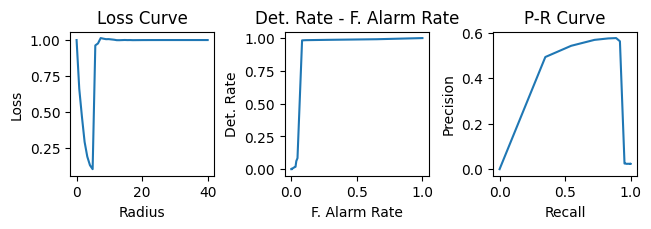

Optimal Radius for small dataset: 4.8988367346938775
PRAUC for small dataset: 0.40923979707633173


In [15]:
# Small Dataset
best_radius_S, prauc_S = pr_curve(MIN_RADIUS, MAX_RADIUS, NUM_STEPS, DETECTORS_S, val_ben_sm, val_att_sm)
print(f"Optimal Radius for small dataset: {best_radius_S}")
print(f"PRAUC for small dataset: {prauc_S}")

Results for r = 0.001 | TN: 41000, FP: 0, FN: 1000, TP: 0
Precision: 0
Recall: 0.0
Results for r = 0.8173061224489796 | TN: 41000, FP: 0, FN: 998, TP: 2
Precision: 1.0
Recall: 0.002
Results for r = 1.633612244897959 | TN: 40996, FP: 4, FN: 987, TP: 13
Precision: 0.7647058823529411
Recall: 0.013
Results for r = 2.4499183673469385 | TN: 40986, FP: 14, FN: 952, TP: 48
Precision: 0.7741935483870968
Recall: 0.048
Results for r = 3.2662244897959183 | TN: 40945, FP: 55, FN: 905, TP: 95
Precision: 0.6333333333333333
Recall: 0.095
Results for r = 4.0825306122448985 | TN: 40897, FP: 103, FN: 839, TP: 161
Precision: 0.6098484848484849
Recall: 0.161
Results for r = 4.8988367346938775 | TN: 40844, FP: 156, FN: 789, TP: 211
Precision: 0.5749318801089919
Recall: 0.211
Results for r = 5.715142857142857 | TN: 40788, FP: 212, FN: 740, TP: 260
Precision: 0.5508474576271186
Recall: 0.26
Results for r = 6.531448979591837 | TN: 40741, FP: 259, FN: 698, TP: 302
Precision: 0.5383244206773619
Recall: 0.302
Res

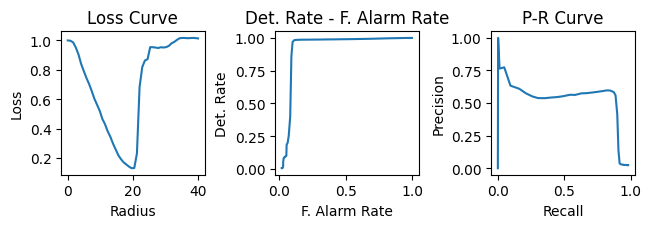

Optimal Radius for medium dataset: 19.59234693877551
PRAUC for medium dataset: 0.533764300537262


In [16]:
# Medium Dataset
best_radius_M, prauc_M = pr_curve(MIN_RADIUS, MAX_RADIUS, NUM_STEPS, DETECTORS_M, val_ben_md, val_att_md)
print(f"Optimal Radius for medium dataset: {best_radius_M}")
print(f"PRAUC for medium dataset: {prauc_M}")

Results for r = 0.001 | TN: 41000, FP: 0, FN: 1000, TP: 0
Precision: 0
Recall: 0.0
Results for r = 0.8173061224489796 | TN: 41000, FP: 0, FN: 998, TP: 2
Precision: 1.0
Recall: 0.002
Results for r = 1.633612244897959 | TN: 40998, FP: 2, FN: 990, TP: 10
Precision: 0.8333333333333334
Recall: 0.01
Results for r = 2.4499183673469385 | TN: 40991, FP: 9, FN: 961, TP: 39
Precision: 0.8125
Recall: 0.039
Results for r = 3.2662244897959183 | TN: 40964, FP: 36, FN: 936, TP: 64
Precision: 0.64
Recall: 0.064
Results for r = 4.0825306122448985 | TN: 40938, FP: 62, FN: 883, TP: 117
Precision: 0.6536312849162011
Recall: 0.117
Results for r = 4.8988367346938775 | TN: 40911, FP: 89, FN: 826, TP: 174
Precision: 0.6615969581749049
Recall: 0.174
Results for r = 5.715142857142857 | TN: 40873, FP: 127, FN: 769, TP: 231
Precision: 0.6452513966480447
Recall: 0.231
Results for r = 6.531448979591837 | TN: 40839, FP: 161, FN: 711, TP: 289
Precision: 0.6422222222222222
Recall: 0.289
Results for r = 7.34775510204081

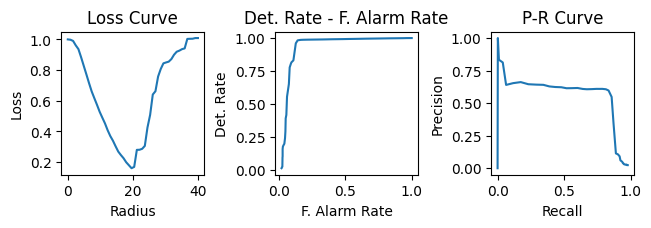

Optimal Radius for large dataset: 19.59234693877551
PRAUC for large dataset: 0.5627033747208696


In [17]:
# Large Dataset
best_radius_L, prauc_L = pr_curve(MIN_RADIUS, MAX_RADIUS, NUM_STEPS, DETECTORS_L, val_ben_lg, val_att_lg)
print(f"Optimal Radius for large dataset: {best_radius_L}")
print(f"PRAUC for large dataset: {prauc_L}")

# Evaluation Function

In [18]:
def evaluate(optimal_radius, detrs, att_test, ben_test):
    
    def affinity(v1 : np.ndarray, v2 : np.ndarray):
        ''' Manhattan distance between vectors '''
        return np.sum(np.abs(v1 - v2), axis=-1)
    
    y_attack_labels = np.zeros((1, len(att_test)), dtype=np.int8)
    #print(y_attack_labels.shape)
    y_ben_labels = np.ones((1, len(ben_test)), dtype=np.int8)
    #print(y_ben_labels.shape)
    y_test = np.concatenate((y_attack_labels, y_ben_labels), axis=1)[0]
    #print(y_test.shape)

    pred = []
    done = False

    for inst in att_test:
        done = False
        for i in range(0, len(detrs)-1):
              aff = affinity(inst, detrs[i])
              if aff < optimal_radius:
                pred.append(1) # Predicted benign
                done = True
                break
        if not done:
            pred.append(0) # Predicted attack

    done = False
    for inst in ben_test:
        done = False
        for i in range(0, len(detrs)-1):
              aff = affinity(inst, detrs[i])
              if aff < optimal_radius:
                pred.append(1) # Predicted benign
                done = True
                break
        if not done:
            pred.append(0) # Predicted attack

    y_pred = np.asarray(pred, dtype=np.int8)

    print(classification_report(y_test, y_pred, digits = 3, target_names = ["attack", "benign"]))

In [19]:
# Small Dataset
evaluate(best_radius_S, DETECTORS_S, ATTACK_TEST_S, BENIGN_TEST_S)

              precision    recall  f1-score   support

      attack      0.998     0.982     0.990     41000
      benign      0.551     0.907     0.686      1000

    accuracy                          0.980     42000
   macro avg      0.774     0.944     0.838     42000
weighted avg      0.987     0.980     0.983     42000



In [20]:
# Medium Dataset
evaluate(best_radius_M, DETECTORS_M, ATTACK_TEST_M, BENIGN_TEST_M)

              precision    recall  f1-score   support

      attack      0.996     0.982     0.989     41000
      benign      0.543     0.858     0.665      1000

    accuracy                          0.979     42000
   macro avg      0.770     0.920     0.827     42000
weighted avg      0.986     0.979     0.982     42000



In [21]:
# Large Dataset
evaluate(best_radius_L, DETECTORS_L, ATTACK_TEST_L, BENIGN_TEST_L)

              precision    recall  f1-score   support

      attack      0.996     0.982     0.989     41000
      benign      0.528     0.837     0.648      1000

    accuracy                          0.978     42000
   macro avg      0.762     0.909     0.818     42000
weighted avg      0.985     0.978     0.981     42000



# Export Detectors

In [22]:
#Get rid of [] in the txt file before copying to cpp file

# Small Dataset
interm_S = [list(n) for n in DETECTORS_S]
out_S = repr(list(itertools.chain.from_iterable(interm_S)))
with open("detectors_S.txt", "w") as f:
    f.write(out_S)
    
# Medium Dataset
interm_M = [list(n) for n in DETECTORS_M]
out_M = repr(list(itertools.chain.from_iterable(interm_M)))
with open("detectors_M.txt", "w") as f:
    f.write(out_M)

# Large Dataset
interm_L = [list(n) for n in DETECTORS_L]
out_L = repr(list(itertools.chain.from_iterable(interm_L)))
with open("detectors_L.txt", "w") as f:
    f.write(out_L)